# Analysis of Chemeoproteomics data from the Kuster lab

In [43]:
import MScausality.data_analysis.gene_set as gs
import MScausality.data_analysis.normalization as norm
from MScausality.graph_construction.indra_networks import analysis_uniprot
from MScausality.graph_construction.graph import GraphBuilder
from MScausality.graph_construction.root_node import build_root_network
from MScausality.causal_model.LVM import LVM

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import pyro

from indra_cogex.client import Neo4jClient
from y0.dsl import Variable, P
from y0.algorithm.identify import Identification, identify

import os
from dotenv import load_dotenv 
load_dotenv()

# from indra_cogex.client import Neo4jClient
pd.set_option('display.max_rows', 100)
%matplotlib inline

## Load Data

In [74]:
msstats_data_all = pd.read_csv("../../data/kuster_data/combined_summarized_full_norm.csv")
msstats_data = msstats_data_all[msstats_data_all["GROUP"] == "DMSO"]
msstats_data.loc[:, "originalRUN"] = msstats_data.loc[:, "originalRUN"] + "_" + msstats_data.loc[:, "Drug"]
msstats_data = msstats_data[-msstats_data["Protein"].str.contains(";")]

/var/folders/v7/y32f7x653v9cx3jmt128bnhh0000gp/T/ipykernel_16701/1071004825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msstats_data.loc[:, "originalRUN"] = msstats_data.loc[:, "originalRUN"] + "_" + msstats_data.loc[:, "Drug"]


In [75]:
gene_map = pd.read_csv("../../data/kuster_data/idmapping_2024_08_12.tsv", sep="\t")
msstats_data = pd.merge(msstats_data, gene_map, how='left', 
                        left_on="Protein", right_on='From')
msstats_data.loc[:, "Protein"] = msstats_data.loc[:, 'To']

In [76]:
msstats_data.head()

,RUN,Protein,LogIntensities,originalRUN,GROUP,SUBJECT,TotalGroupMeasurements,NumMeasuredFeature,MissingPercentage,more50missing,NumImputedFeature,Drug,From,To
0,9,ESYT2,20.260002,01201_D08_P012169_B00_A00_R1_Abemaciclib,DMSO,DMSO,10,6,0.400000,False,4,Abemaciclib,A0FGR8,ESYT2
1,9,CNOT1,18.597965,01201_D08_P012169_B00_A00_R1_Abemaciclib,DMSO,DMSO,8,3,0.625000,True,5,Abemaciclib,A5YKK6,CNOT1
2,9,FBLL1,21.499795,01201_D08_P012169_B00_A00_R1_Abemaciclib,DMSO,DMSO,1,1,0.000000,False,0,Abemaciclib,A6NHQ2,FBLL1
3,9,TBKBP1,19.756849,01201_D08_P012169_B00_A00_R1_Abemaciclib,DMSO,DMSO,12,7,0.416667,False,5,Abemaciclib,A7MCY6,TBKBP1
4,9,MYO1G,19.741453,01201_D08_P012169_B00_A00_R1_Abemaciclib,DMSO,DMSO,12,4,0.666667,True,8,Abemaciclib,B0I1T2,MYO1G


In [79]:
msstats_data = msstats_data.groupby(["Protein", "originalRUN"])["LogIntensities"].max().reset_index()

## Normalize Data

In [80]:
msstats_data = norm.normalize(msstats_data)
msstats_data.head()

,Protein,originalRUN,LogIntensities
0,A2M,01439_F09_P014595_B00_A00_R2_BMS-777607_withCAKI,0.004841
1,AAAS,00706_D03_P005256_R1_GSK-690693,-0.079931
2,AAAS,00726_B02_P005466_B00_A00_R1_Gefitinib,0.031492
3,AAAS,00726_D03_P005476_B00_A00_R1_Imatinib,0.027577
4,AAAS,00729_H10_P005574_B00_A00_R1_Crizotinib,0.197771


## Find gene sets with high correlation

In [82]:
input_data = gs.prep_msstats_data(msstats_data, gene_map=None, parse_gene=False)
input_data = input_data.reset_index(drop=True)
input_data.columns.name = None
corr_data = gs.gen_correlation_matrix(input_data, methods=["pearson"], abs_corr=True)

Correlation matrix for pearson:


In [98]:
corr_data["pearson"].loc[corr_data["pearson"]["value"] > .99, "value"] = 0.0

In [99]:
corr_data["pearson"][(corr_data["pearson"]["value"] < 1.) & 
                     (corr_data["pearson"]["value"] > .5)].head(20)

,value,index
9,0.564577,"(AAAS, AATF)"
10,0.522684,"(AAAS, ABCA13)"
11,0.542750,"(AAAS, ABCB10)"
18,0.884218,"(AAAS, ABCC4)"
27,0.659597,"(AAAS, ABHD11)"
32,0.719887,"(AAAS, ABI1)"
51,0.788204,"(AAAS, ACBD5)"
54,0.557839,"(AAAS, ACO1)"
60,0.539158,"(AAAS, ACOT8)"
97,0.874876,"(AAAS, ADAM9)"


array([[<Axes: title={'center': 'value'}>]], dtype=object)

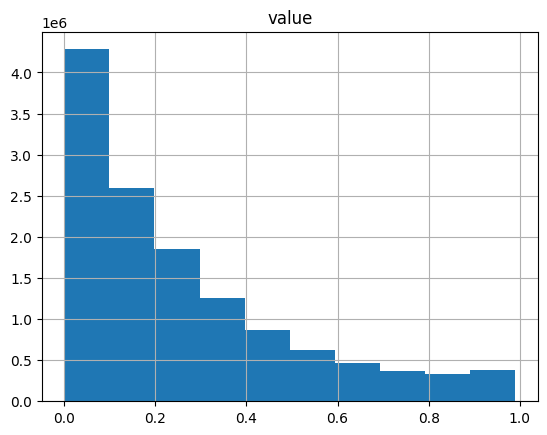

In [100]:
corr_data["pearson"].hist()

### Regulatory pathways

In [101]:
regulatory_paths = gs.test_gene_sets(corr_data, input_data.columns.values, 
                                     "../../data/gene_sets/regulatory_pathways.json", 
                                     threshold=0.33)
regulatory_paths

AAANWWTGC_UNKNOWN
AAAYRNCTG_UNKNOWN
AAAYWAACM_HFH4_01
AACTTT_UNKNOWN
AACWWCAANK_UNKNOWN
AACYNNNNTTCCS_UNKNOWN
AAGWWRNYGGC_UNKNOWN
ACAWNRNSRCGG_UNKNOWN
ACAWYAAAG_UNKNOWN
ACCTGTTG_UNKNOWN
ACTAYRNNNCCCR_UNKNOWN
ACTWSNACTNY_UNKNOWN
ADA2_TARGET_GENES
ADCYAP1_TARGET_GENES
ADNP_TARGET_GENES
AEBP2_TARGET_GENES
AFP1_Q6
AGCYRWTTC_UNKNOWN
AHR_01
AHR_Q5
AHRARNT_01
AHRARNT_02
AHRR_TARGET_GENES
ALKBH3_TARGET_GENES
ALPHACP1_01
ALX4_01
ALX4_TARGET_GENES
AMEF2_Q6
AML1_01
AML1_Q6
AML_Q6
AP1_01
AP1_C
AP1_Q2
AP1_Q2_01
AP1_Q4
AP1_Q4_01
AP1_Q6
AP1_Q6_01
AP1FJ_Q2
AP2_Q3
AP2_Q6
AP2_Q6_01
AP2ALPHA_01
AP2GAMMA_01
AP2REP_01
AP3_Q6
AP4_01
AP4_Q5
AP4_Q6
AP4_Q6_01
AR_01
AR_02
AR_03
AR_Q2
AR_Q6
AREB6_01
AREB6_02
AREB6_03
AREB6_04
ARGGGTTAA_UNKNOWN
ARHGAP35_TARGET_GENES
ARID3B_TARGET_GENES
ARID5B_TARGET_GENES
ARNT2_TARGET_GENES
ARNT_01
ARNT_02
ARP1_01
ASH1L_TARGET_GENES
ASXL2_TARGET_GENES
ATCMNTCCGY_UNKNOWN
ATF1_Q6
ATF3_Q6
ATF4_Q2
ATF5_TARGET_GENES
ATF6_01
ATF6_TARGET_GENES
ATF_01
ATF_B
ATGGYGGA_UNKNOWN
ATM_TARGET_GE

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent,freq_node_percent,differential_percent
0,AAANWWTGC_UNKNOWN,pearson,195,42,0.215385,861,112,0.130081,0.406250,NaN
1,AAAYRNCTG_UNKNOWN,pearson,375,95,0.253333,4465,708,0.158567,0.379747,NaN
2,AAAYWAACM_HFH4_01,pearson,262,60,0.229008,1770,296,0.167232,0.408163,NaN
3,AACTTT_UNKNOWN,pearson,1928,468,0.242739,109278,18043,0.165111,0.493473,NaN
4,AACWWCAANK_UNKNOWN,pearson,146,44,0.301370,946,180,0.190275,0.487179,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,ZSCAN4_TARGET_GENES,pearson,1458,347,0.237997,60031,9927,0.165365,0.430070,NaN
1111,ZSCAN5B_TARGET_GENES,pearson,85,22,0.258824,231,39,0.168831,0.400000,NaN
1112,ZSCAN5C_TARGET_GENES,pearson,152,41,0.269737,820,192,0.234146,0.473684,NaN
1113,ZSCAN5DP_TARGET_GENES,pearson,1533,526,0.343118,138075,23814,0.172471,0.452489,NaN


In [102]:
regulatory_paths.to_csv("../../data/kuster_data/regulatory_paths_kuster_corr.csv", index=False)

In [103]:
regulatory_paths[regulatory_paths["percent"] > .2]

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent,freq_node_percent,differential_percent
21,AHRARNT_02,pearson,15,4,0.266667,6,3,0.500000,0.000000,NaN
26,ALX4_TARGET_GENES,pearson,33,8,0.242424,28,6,0.214286,0.285714,NaN
31,AP1_01,pearson,271,85,0.313653,3570,838,0.234734,0.474359,NaN
32,AP1_C,pearson,277,90,0.324910,4005,837,0.208989,0.506329,NaN
37,AP1_Q6,pearson,260,91,0.350000,4095,867,0.211722,0.462500,NaN
...,...,...,...,...,...,...,...,...,...,...
1080,ZNF704_TARGET_GENES,pearson,71,27,0.380282,351,78,0.222222,0.500000,NaN
1091,ZNF781_TARGET_GENES,pearson,214,47,0.219626,1081,217,0.200740,0.317073,NaN
1094,ZNF791_TARGET_GENES,pearson,67,10,0.149254,45,14,0.311111,0.333333,NaN
1106,ZSCAN26_TARGET_GENES,pearson,5,3,0.600000,3,1,0.333333,0.000000,NaN


In [105]:
msstats_data_all["Drug"].unique()

array(['4CellLines', 'Abemaciclib', 'AC-480_inBT474', 'AC-480',
       'ACTB-1003', 'AEE-788_inBT474', 'AEE-788', 'AEW-541',
       'Afatinib_inBT474', 'Afatinib', 'Alectinib', 'Alisertib',
       'Alvocidib', 'AMG-208', 'AMG-208_withCAKI', 'AMG-900',
       'Amuvatinib', 'Apatinib', 'Apitolisib', 'ARRY-380_inBT474',
       'ARRY-380', 'ASP-3026', 'AT-13148', 'AT-7519', 'AT-9283',
       'AV-412_inBT474', 'AV-412', 'Axitinib', 'AXL-1717', 'AZD-1208',
       'AZD-1480', 'AZD-2014', 'AZD-4547', 'AZD-5363', 'AZD-5438',
       'AZD-7762', 'AZD-8055', 'AZD-8186', 'AZD-8330', 'Bafetinib',
       'Barasertib_HQPA', 'Barasertib', 'Baricitinib', 'BGT-226',
       'BI-2536', 'BI-847325', 'Binimetinib', 'BMS-387032',
       'BMS-690514_inBT474', 'BMS-690514', 'BMS-754807', 'BMS-777607',
       'BMS-777607_withCAKI', 'BMS-911543', 'Bosutinib',
       'Brivanib_alaninate', 'Brivanib', 'Buparlisib', 'BYL-719',
       'Cabozantinib', 'Cabozantinib_withCAKI', 'Canertinib_inBT474',
       'Canertinib',